## Import & Data Load

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor


train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [12]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year']=df['ATA'].dt.year
    df['month']=df['ATA'].dt.month
    df['hour'] = df['ATA'].dt.hour
    df['weekday'] = df['ATA'].dt.weekday

train['WEEKEND'] = train['weekday'].apply(lambda x: 1 if x >= 5 else 0)
test['WEEKEND'] = test['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# datetime 컬럼 제거
train.drop(columns=['ATA','ID','SHIPMANAGER','FLAG'], inplace=True)
test.drop(columns=['ATA','ID','SHIPMANAGER','FLAG'], inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO','SHIP_TYPE_CATEGORY']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"): #tqdm? 진행상황 표시 
    le = LabelEncoder() # 카테고리 데이터들을 수치형 데이터로 변환
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_) # 클래스 집합 생성
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist() # 객체 클래스 리스트 생성
    bisect.insort_left(le_classes, '-1') # -1을 리스트에 삽입
    le.classes_ = np.array(le_classes) 
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

#train = pd.get_dummies(train,columns=['SHIP_TYPE_CATEGORY'])
#test = pd.get_dummies(test,columns=['SHIP_TYPE_CATEGORY'])
# [배 수치항목서 결측치 존재하는 행 제거]

# BUILT열 제거(보류)
#train.drop(columns=['BUILT','U_WIND','V_WIND'],axis=1,inplace=True)
#test.drop(columns=['BUILT','U_WIND','V_WIND'],axis=1,inplace=True)


Encoding features: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


In [17]:
train.dropna(subset=['LENGTH'], inplace=True)

In [6]:
from pycaret.regression import *

reg_test_1 = setup(data=train,
                   target='CI_HOUR',
                   train_size= 0.7,
                   normalize=True,
                   normalize_method='robust',
                   fold=5)

,Description,Value
0,Session id,2529
1,Target,CI_HOUR
2,Target type,Regression
3,Original data shape,"(391939, 23)"
4,Transformed data shape,"(391939, 23)"
5,Transformed train set shape,"(313551, 23)"
6,Transformed test set shape,"(78388, 23)"
7,Numeric features,18
8,Rows with missing values,0.0%
9,Preprocess,True


In [7]:
best = compare_models(sort='mae')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,53.7973,29450.1551,171.5960,-0.0114,1.5468,1.2858,0.8300
lightgbm,Light Gradient Boosting Machine,56.3785,21340.9260,146.0631,0.2672,1.3187,9.2733,1.7020
rf,Random Forest Regressor,56.9675,21490.8008,146.5803,0.2620,1.1552,9.6590,36.1760
et,Extra Trees Regressor,57.0599,21692.5034,147.2655,0.2551,1.1708,9.0959,22.4520
catboost,CatBoost Regressor,57.1512,20834.6934,144.3213,0.2846,1.6234,8.8289,9.8020
xgboost,Extreme Gradient Boosting,57.3153,21218.1895,145.6425,0.2714,1.5951,7.8543,0.8880
par,Passive Aggressive Regressor,57.5545,29036.5444,170.3848,0.0028,1.8259,2.0998,0.3400
gbr,Gradient Boosting Regressor,61.1838,22895.9754,151.2969,0.2138,1.7276,9.6444,20.7400
knn,K Neighbors Regressor,62.5357,26151.2297,161.6949,0.1020,1.6715,4.7305,12.6820
dt,Decision Tree Regressor,70.8578,42706.7540,206.6417,-0.4671,1.2506,9.0132,1.0940


In [8]:
best_tune = tune_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,55.0068,28461.7339,168.7061,0.0126,1.7692,2.0552
1,56.1938,29838.9098,172.7394,0.0067,1.7715,1.7906
2,55.8594,29328.4269,171.2554,0.0103,1.7650,1.7727
3,54.6461,28656.0957,169.2811,0.0129,1.7649,1.6186
4,54.3895,27642.9923,166.2618,0.0147,1.7620,1.6856
Mean,55.2191,28785.6317,169.6488,0.0114,1.7665,1.7846
Std,0.6959,752.5072,2.2194,0.0028,0.0034,0.1488


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [9]:
last_predict = predict_model(best_tune, data= test)
last_predict.loc[last_predict['prediction_label']<0,'prediction_label']=0
last_predict

,ARI_CO,ARI_PO,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,...,BN,ATA_LT,PORT_SIZE,month,weekday,SHIP_TYPE_CATEGORY_Bulk,SHIP_TYPE_CATEGORY_Cargo,SHIP_TYPE_CATEGORY_Container,SHIP_TYPE_CATEGORY_Tanker,prediction_label
0,0.708333,0.205882,1.826589,50.0,18,117000,30.0,20.0,109000,340.0,...,1.587063,0.826087,0.002615,0.454545,0,False,False,True,False,4.914504
1,0.166667,0.882353,25.399385,10.0,13,3810,10.0,10.0,2560,80.0,...,2.663972,0.260870,0.001028,0.363636,0,False,True,False,False,24.672203
2,0.166667,0.441176,111.079468,20.0,26,10900,10.0,10.0,8440,140.0,...,3.255316,0.347826,0.001743,1.000000,0,False,False,True,False,52.809282
3,0.083333,0.186275,9.175258,30.0,9,55800,20.0,10.0,31500,190.0,...,NaN,0.086957,0.000182,0.909091,0,True,False,False,False,24.345241
4,0.333333,0.647059,0.000000,30.0,19,39800,20.0,10.0,33000,220.0,...,NaN,0.434783,0.000552,0.818182,0,False,False,True,False,1.637166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220486,0.041667,0.745098,21.712732,60.0,15,298000,30.0,20.0,151000,330.0,...,NaN,0.565217,0.000080,0.272727,0,True,False,False,False,57.158791
220487,0.083333,0.225490,4.870490,30.0,9,80500,20.0,10.0,42700,220.0,...,NaN,0.565217,0.000039,0.636364,0,True,False,False,False,25.213070
220488,0.333333,0.862745,17.068287,10.0,14,1200,0.0,0.0,500,60.0,...,2.405268,1.000000,0.000264,0.545455,1,False,False,False,True,60.726384
220489,0.166667,0.607843,0.000000,10.0,27,3420,10.0,0.0,2000,80.0,...,2.199039,0.956522,0.000595,1.000000,0,False,True,False,False,14.859976


In [10]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = last_predict['prediction_label']
submit.to_csv('./baseline_submit.csv', index=False)

CORR HEATMAP

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_list = ['ARI_CO','ARI_PO','ATA_LT','month']
train[scale_list] = scaler.fit_transform(train[scale_list])
test[scale_list] = scaler.fit_transform(test[scale_list])


In [4]:
# 결측치가 있는 행과 없는 행 분리
X_missing = train[train.isnull().any(axis=1)]
X_no_missing = train.dropna()

# 결측치가 없는 데이터의 특성과 타겟 분리
y_train = X_no_missing[['BN','AIR_TEMPERATURE','U_WIND','V_WIND']]
X_train = X_no_missing[['ARI_CO','ARI_PO','ATA_LT','month']]


# 결측치가 있는 데이터에서 예측할 특성 분리
X_missing_test = X_missing[['ARI_CO','ARI_PO','ATA_LT','month']]

# KNN 회귀 모델 생성 및 훈련
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)

# 결측치 예측
predicted_values = knn_regressor.predict(X_missing_test)

# BN 열과 air_temperature 열의 결측치 인덱스 찾기
bn_nan_indices = train.index[train['BN'].isna()]
air_temp_nan_indices = train.index[train['AIR_TEMPERATURE'].isna()]
U_WIND_nan_indices = train.index[train['U_WIND'].isna()]
V_WIND_nan_indices = train.index[train['V_WIND'].isna()]

# BN 열의 결측치 채우기
for i, idx in enumerate(bn_nan_indices):
    if i < len(predicted_values):  # 배열의 길이를 초과하지 않도록 확인
        train.at[idx, 'BN'] = predicted_values[i, 0]

# air_temperature 열의 결측치 채우기
for i, idx in enumerate(air_temp_nan_indices):
    if i < len(predicted_values):  # 배열의 길이를 초과하지 않도록 확인
        train.at[idx, 'AIR_TEMPERATURE'] = predicted_values[i, 1]

# U_WIND 열의 결측치 채우기
for i, idx in enumerate(U_WIND_nan_indices):
    if i < len(predicted_values):  # 배열의 길이를 초과하지 않도록 확인
        train.at[idx, 'U_WIND'] = predicted_values[i, 2]

# V_WIND 열의 결측치 채우기
for i, idx in enumerate(V_WIND_nan_indices):
    if i < len(predicted_values):  # 배열의 길이를 초과하지 않도록 확인
        train.at[idx, 'V_WIND'] = predicted_values[i, 3]        



In [5]:
# 결측치 처리 여부
train.isna().sum()

ARI_CO                          0
ARI_PO                          0
DIST                            0
BREADTH                         1
BUILT                           0
DEADWEIGHT                      0
DEPTH                           1
DRAUGHT                         1
GT                              0
LENGTH                          1
U_WIND                          0
V_WIND                          0
AIR_TEMPERATURE                 0
BN                              0
ATA_LT                          0
PORT_SIZE                       0
CI_HOUR                         0
month                           0
weekday                         0
SHIP_TYPE_CATEGORY_Bulk         0
SHIP_TYPE_CATEGORY_Cargo        0
SHIP_TYPE_CATEGORY_Container    0
SHIP_TYPE_CATEGORY_Tanker       0
dtype: int64

## 각 열의 boxplot을 통해 열 특성 확인

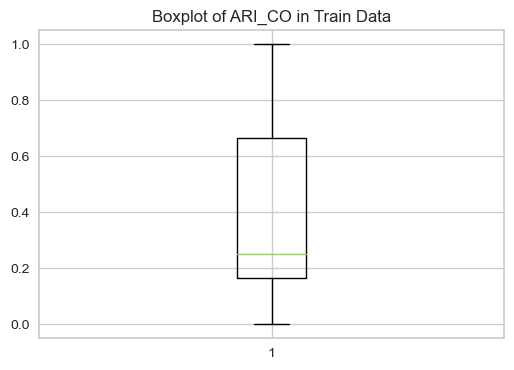

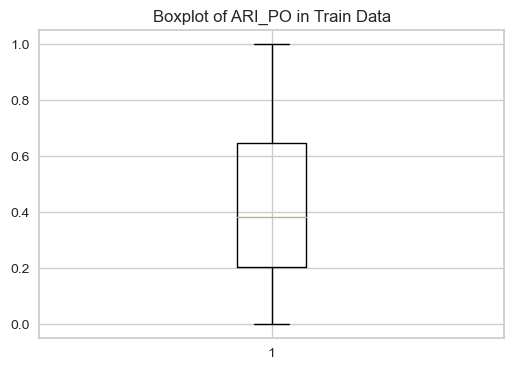

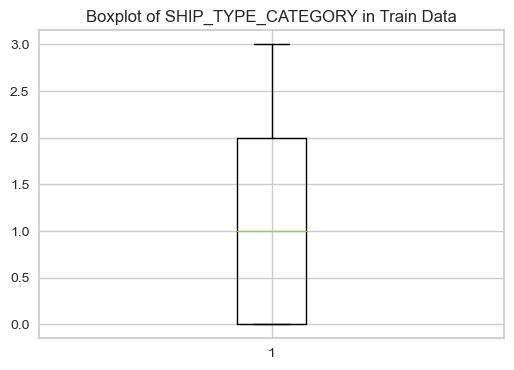

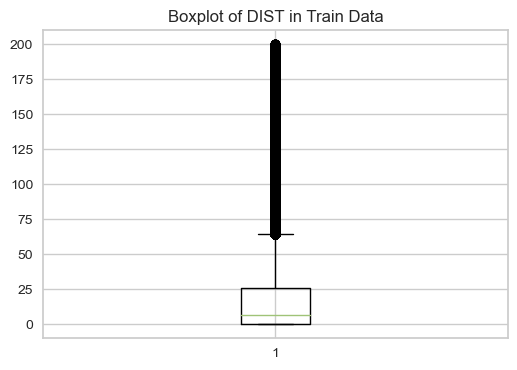

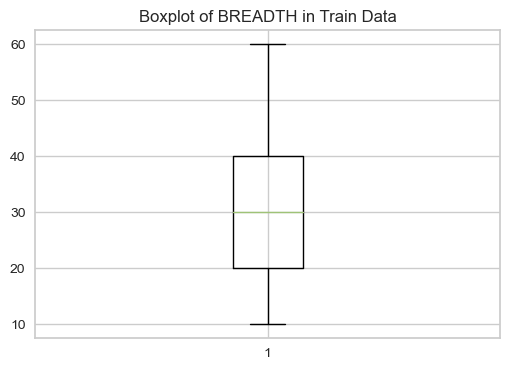

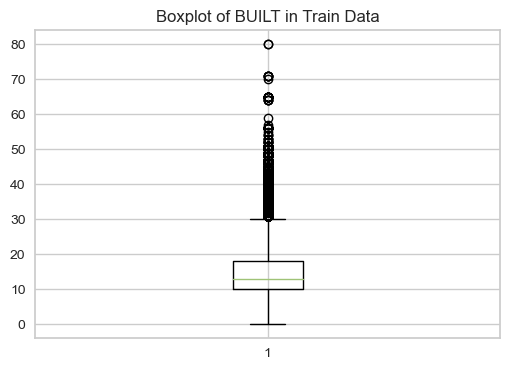

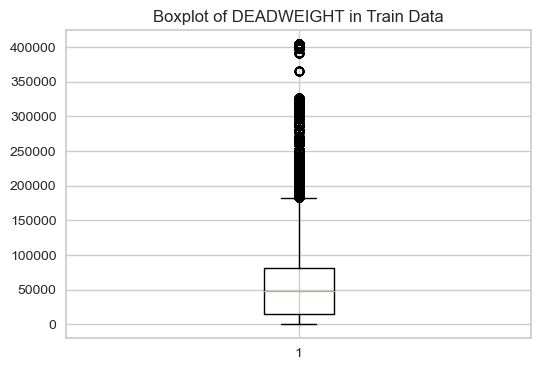

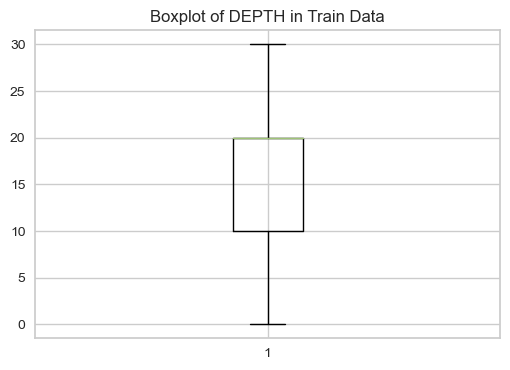

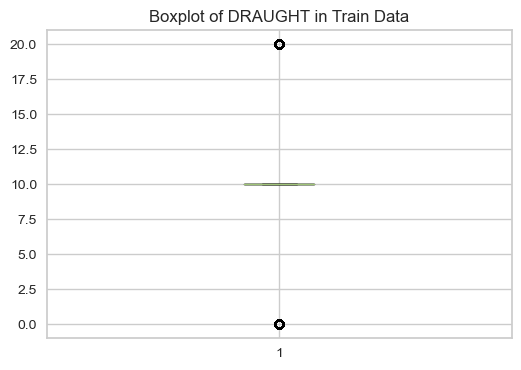

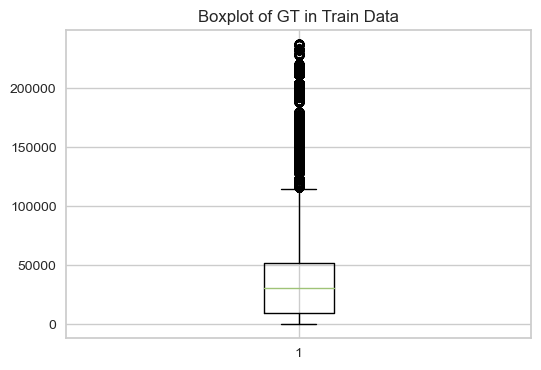

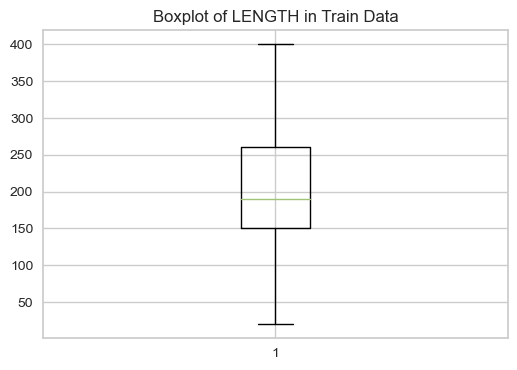

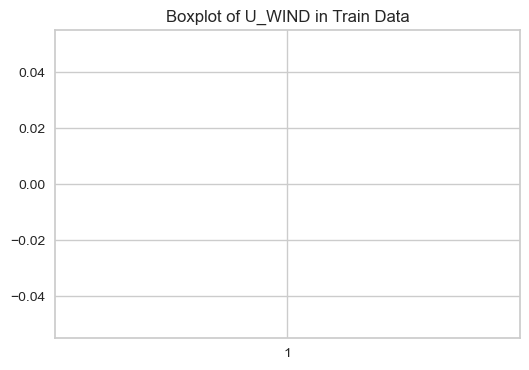

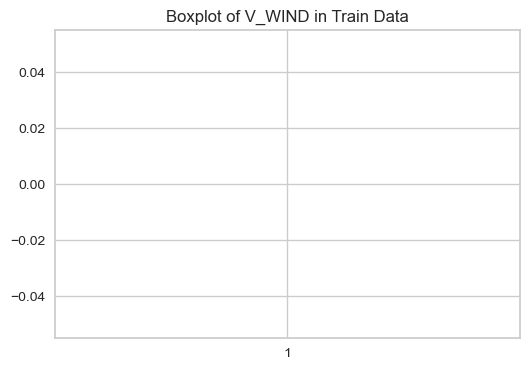

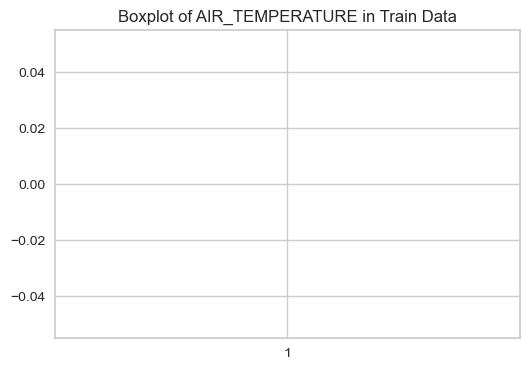

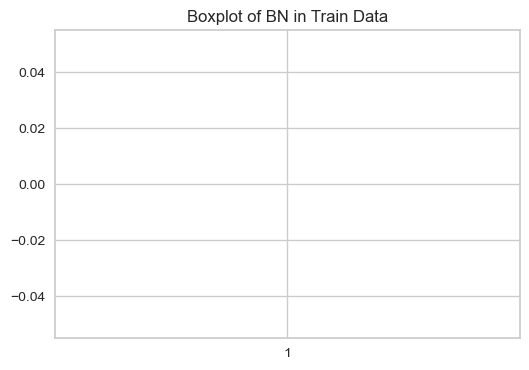

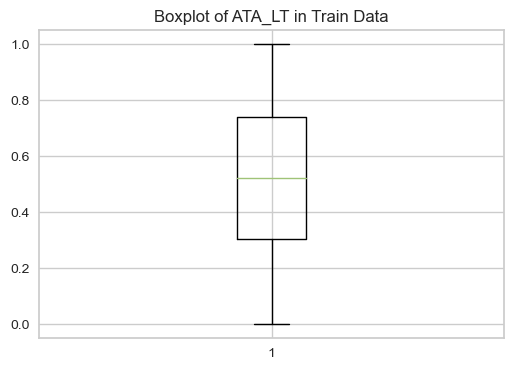

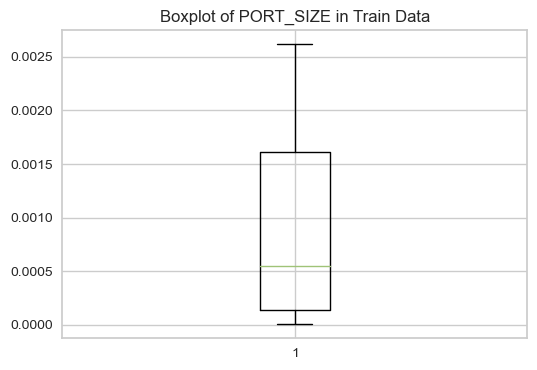

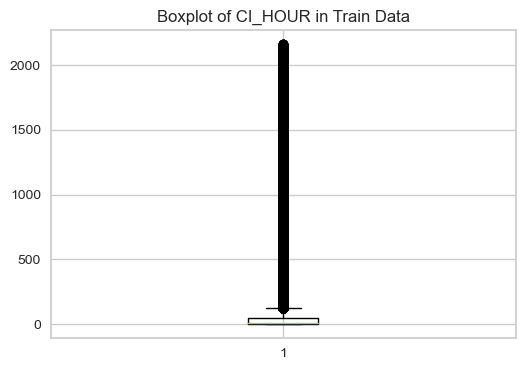

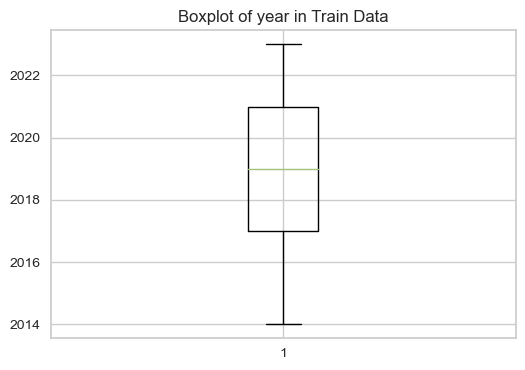

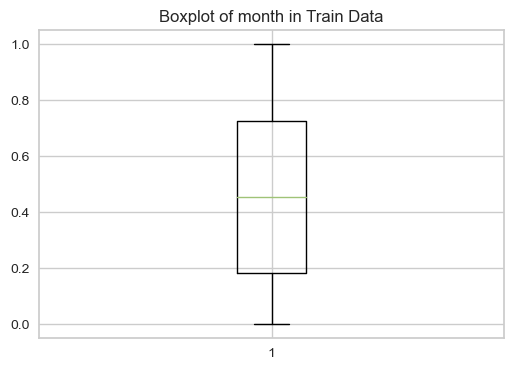

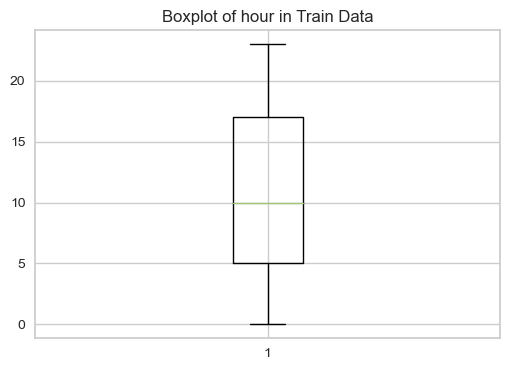

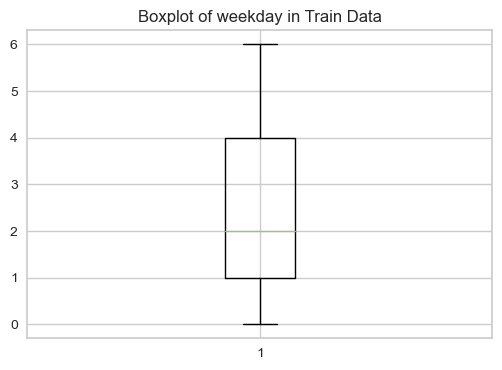

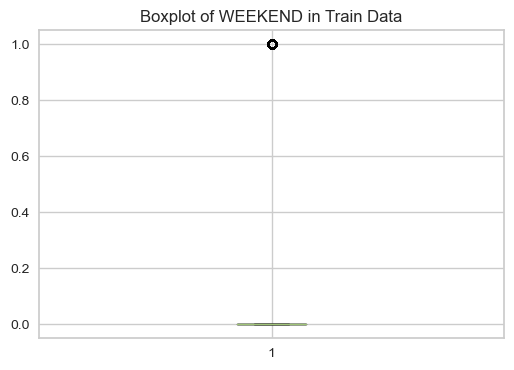

In [18]:
for feature in train.columns:
    plt.figure(figsize=(6, 4))  # 그래프의 크기 설정
    plt.boxplot(train[feature])  # 현재 feature에 대한 boxplot 그리기
    plt.title(f'Boxplot of {feature} in Train Data')  # 그래프 제목 설정
    plt.show()

Scaling

In [ ]:
features = ['DIST','BREADTH','DEADWEIGHT','DEPTH','GT','LENGTH','AIR_TEMPERATURE','BN','PORT_SIZE','hour']

In [ ]:
# 이상치 존재하는 feature는 RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.fit_transform(test[features])

## 모델 학습 및 특성 중요도 확인

In [ ]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:



X = train.drop(columns = ['CI_HOUR'])
y = train['CI_HOUR']
k = 5

# Define parameter grid for each model
param_grid_tree = {
    'max_depth': [3, 5, 7]
}

param_grid_forest = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7]
}

param_grid_cat = {
    'iterations': [50, 100, 150],
    'depth': [3, 5, 7]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7]
}

# Models
models = {
    'DecisionTree': (DecisionTreeRegressor(), param_grid_tree),
    'RandomForest': (RandomForestRegressor(), param_grid_forest),
    'CatBoost': (CatBoostRegressor(), param_grid_cat),
    'XGBoost': (XGBRegressor(), param_grid_xgb)
}

# Perform grid search for each model
best_estimators = {}
for name, (model, param_grid) in tqdm(models.items(), desc='Optimizing models'):
    grid_search = GridSearchCV(model, param_grid, cv=k, scoring='neg_mean_absolute_error')
    grid_search.fit(X, y)
    best_estimators[name] = grid_search.best_estimator_

# Print best parameters for each model
for name, estimator in best_estimators.items():
    print(f'Best parameters for {name}: {estimator.get_params()}')

In [ ]:
DecisionTree = DecisionTreeRegressor(ccp_alpha= 0.0, criterion = 'mae',max_depth=7,max_features = None, max_leaf_nodes = None, min_impurity_decrease = 0.0, min_samples_leaf= 1, min_samples_split= 2, min_weight_fraction_leaf=0.0, random_state = None, splitter = 'best')
RandomForest =  RandomForestRegressor(bootstrap = True, ccp_alpha = 0.0, criterion = 'mae', max_depth = 7, max_features = 1.0, max_leaf_nodes = None, max_samples = None, min_impurity_decrease = 0.0, min_samples_leaf = 1, min_samples_split = 2, min_weight_fraction_leaf = 0.0, n_estimators = 100, n_jobs = None, oob_score = False, random_state = None, verbose = 0, warm_start = False)
CatBoost =  CatBoostRegressor(iterations = 100, depth =  7, loss_function = 'mae')
XGBoost = XGBRegressor(objective =  'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 50, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}

In [ ]:
# Models
model_tree = DecisionTreeRegressor()
model_forest = RandomForestRegressor()
model_cat = CatBoostRegressor()
model_xgb = XGBRegressor()

# Hyper Parameters
k = 5
models = [model_tree, model_forest, model_cat, model_xgb]


kfold = KFold(n_splits = k)

n_iter = 0
models_mae = []
for model in models:
    cv_mae = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        n_iter += 1
        mae = mean_absolute_error(y_test, pred)
        train_size = X_train.shape[0]
        test_size = X_test.shape[0]
        print('\n{0}#{1} 교차검증 MAE :{2}, 학습 데이터 크기: {3}, 검증 데이터 크기: {4}'.format(model,n_iter, mae, train_size, test_size))
        print('{0}#{1} 검증 세트 인덱스 :{2}'.format(model, n_iter, test_index))
        cv_mae.append(mae)
    print(f'## {model}의 평균 검증 MAE: {np.mean(cv_mae)}')
    models_mae.append(np.mean(cv_mae))

## 특성 중요도로부터 Feature Selection

In [ ]:
threshold = 20 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

## K-Fold Model Fitting & Validation

In [ ]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)